In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import pearsonr, spearmanr
from sklearn.cluster import KMeans

import os
from env import username, password, host
import env

import wrangle as w

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',None)

----

## <u>Using Clustering To Minimize Absolute Log Error<u>

#### Reported by Jerry Nolf   -   April 9, 2022

----

### <u>PROJECT DESCRIPTION:<u>
Zillow offers a lot to value to real estate professionals, customers, and the public by offering usable real estate data on its sites. From buying properties to selling them, Zillow offers these resources to help in all facets of the real estate market.

This project has been requested, per email from the Data Science Team, in order to help reduce the absolute log error of Zestimates that have assessed property tax values of single family residences.

#### <u>Project Goal:<u>
The goal of this project is to use all available databases and information in order to reduce absolute log error by using clustering in order to create more refined drivers. Effective clusters can then be encoded and used on a maching learning model in order to reduce absolute log error.

----

### <u>Acquire and Preparing the data:<u>

Our data will be pulled from our Zillow database. In our SQL query, we joined the following relational databases together:
    
    - properties_2017
    - predictions_2017
    - typeconstructiontype
    - airconditioningtype air 
    - architecturalstyletype 
    - buildingclasstype
    - heatingorsystemtype 
    - propertylandusetype 
    - storytype story
    
With these joined, we were able to access the following tables of information for Single Family Residential homes with a transaction date in 2017:

    - parcelid                      
    - bathroomcnt                   
    - bedroomcnt                    
    - calculatedfinishedsquarefeet  
    - fips                          
    - latitude                      
    - longitude                     
    - lotsizesquarefeet             
    - rawcensustractandblock        
    - regionidcounty                
    - roomcnt                       
    - yearbuilt                     
    - structuretaxvaluedollarcnt    
    - taxvaluedollarcnt             
    - assessmentyear                
    - landtaxvaluedollarcnt         
    - taxamount                     
    - logerror                      
    - transactiondate               
    - age                           
    - county                        
    - age_bin                       
    - taxrate                       
    - acres                         
    - acres_bin                     
    - county_code_bin               
    - abs_logerror                  
    - abs_logerror_bin              
    - logerror_bin                  
    - sqft_bin                      
    - structure_dollar_per_sqft     
    - structure_dollar_sqft_bin     
    - land_dollar_per_sqft          
    - lot_dollar_sqft_bin           
    - bath_bed_ratio
    
This will allow for the gathering of all relevant data into one database. Once the data is acquired for the first time, it will create a .csv file that can be pulled from the active directory. An acquire.py file was then created in order to perform the above steps by simply importing wrangle and using it's local 'acquire_df' function.



In [2]:
df = w.acquire_df()
df.shape

Using cached csv


(77574, 68)

In [3]:
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,3100.0,3100.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,633.0,NaN,NaN,33634931.0,-117869207.0,4506.0,NaN,NaN,NaN,NaN,NaN,122,261.0,NaN,6.059063e+07,53571.0,1286.0,NaN,96978.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1465.0,1465.0,1465.0,NaN,NaN,1465.0,NaN,6111.0,1.0,1.0,1.0,0.0,NaN,NaN,34449266.0,-119281531.0,12647.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,NaN,1243.0,1243.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,440.0,NaN,NaN,33886168.0,-117823170.0,8432.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059022e+07,21412.0,1286.0,NaN,97078.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34245180.0,-118240722.0,13038.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LCR110000*,6.037300e+07,396551.0,3101.0,NaN,96330.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,NaN,1312.0,1312.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34185120.0,-118414640.0,278581.0,1.0,NaN,NaN,NaN,1.0,010C,266.0,LAR3,6.037124e+07,12447.0,3101.0,268548.0,96451.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,73681.0,119407.0,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


Once acquire, we must clean the data. The Zillow dataset is EXTREMELY messy and have a lot of null values. For this we will use the clean_df function from our wrangle.py. This function does the following:

    - Limits pulled properties to only single family use homes
    - Limits skewing the data by dropping outliers in categories such as the following:
            - Properties with no bathrooms or bedrooms
            - Properties less than 500 sqft and larger than 3000 sqft
            - Drops missing values within a certain percentage in rows and columns
            - Drops columns deemed unecessary

In [4]:
df = w.clean_df(df)

After our focus is defined a bit more, we can now we create new features that will allow us to dive deeper and create bins of data.

In [5]:
df = w.create_features(df)
df.shape, 77574-46867

((57487, 35), 30707)

In [6]:
df.isna().mean()

parcelid                        0.000000
bathroomcnt                     0.000000
bedroomcnt                      0.000000
calculatedfinishedsquarefeet    0.000000
fips                            0.000000
latitude                        0.000000
longitude                       0.000000
lotsizesquarefeet               0.000000
rawcensustractandblock          0.000000
regionidcounty                  0.000000
roomcnt                         0.000000
yearbuilt                       0.000000
structuretaxvaluedollarcnt      0.000000
taxvaluedollarcnt               0.000000
assessmentyear                  0.000000
landtaxvaluedollarcnt           0.000000
taxamount                       0.000000
logerror                        0.000000
transactiondate                 0.000000
age                             0.000000
county                          0.000000
age_bin                         0.000035
taxrate                         0.000000
acres                           0.000000
acres_bin       

In [7]:
# df = df.dropna()
# df.shape

After all of our prep work, we are left with 30,707 less rows. Our final shape is 46,867 rows and 35 columns

We now are required to split our data into train, validate, and test datasets that are 56, 24, and 20 percent of the dataframe. We will be working with just the train data in exploration in order to limit data leakage.

In [8]:
train, validate, test = w.split_data(df)
train.shape, validate.shape, test.shape

((32192, 35), (13797, 35), (11498, 35))

### <u>Exploring our data:<u>

We can now take a look at the distribution of our features in our training data...

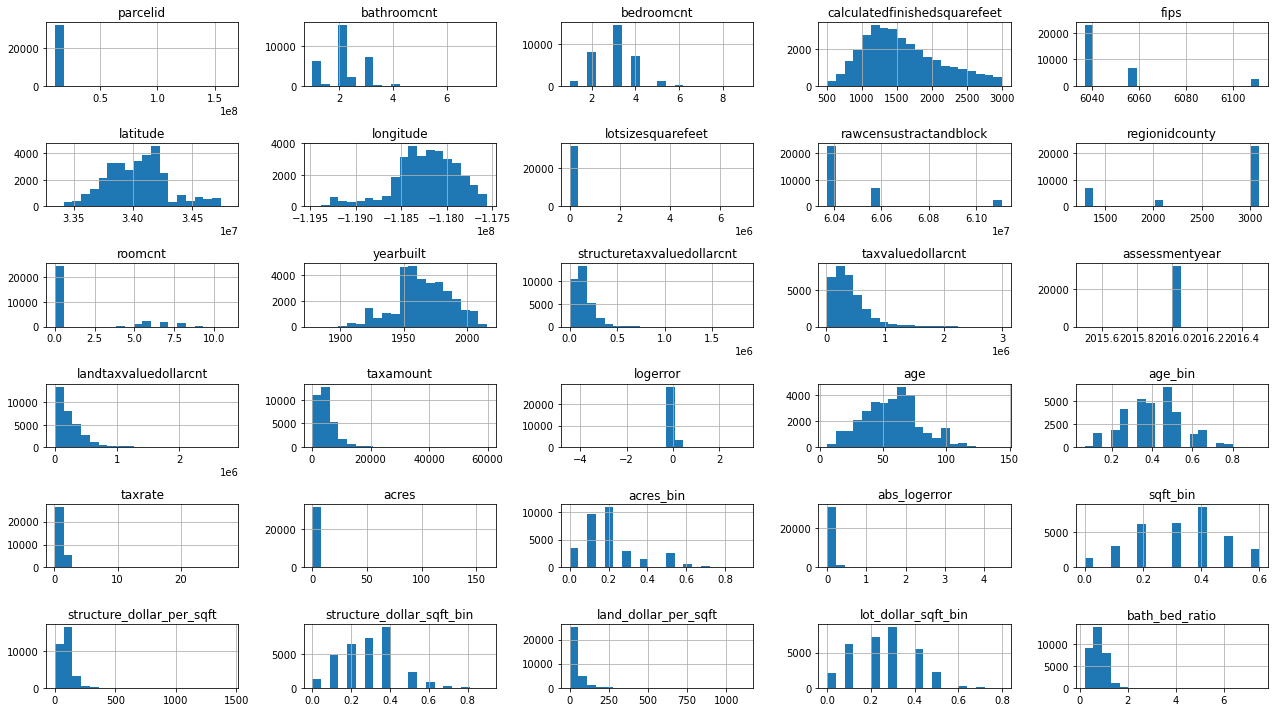

In [9]:
# Make a histogram of all features in the training dataset
train.hist(figsize = (18,10), bins = 20)
plt.tight_layout()

We can also take a look at the distribution of our target variable, 'logerror'.

[(-0.5, 0.5), (0.0, 1200.0)]

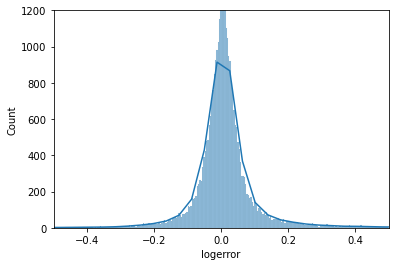

In [10]:
# Create histogram showning the distribution of log error
ax = sns.histplot(data=train, x="logerror", kde=True)
# Set x and y limits to get a closer look
ax.set(xlim = (-.5, .5), ylim = (0, 1200))

We can now go even further to ensure our data is now skewed by using a remove_outliers function from our wrangle.py along with our defined columns we want to drop outliers from. This function will only be used on our training data so that outliers in our validate and test data can be worked with. This function takes in a dataframe and drops the lowest and highest quantiles so that we zoom in on pertinent data.

In [11]:
# Remove any outliers that got through our wrangle and might skew our data
cols = ['bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet',
       'lotsizesquarefeet', 'roomcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount']

w.remove_outliers(train, 2.5, cols)

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcounty,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,age,county,age_bin,taxrate,acres,acres_bin,county_code_bin,abs_logerror,abs_logerror_bin,logerror_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio
47779,11411251,2.0,3.0,1290.0,6037.0,33937628.0,-118322836.0,6005.0,6.037601e+07,3101.0,0.0,1953.0,89043.0,353677.0,2016.0,264634.0,4959.17,-0.035120,2017-06-17,69.0,los_angeles,0.466,1.402175,0.137856,0.1,Los Angeles County,0.035120,"(0.0, 0.05]","(-0.05, 0.05]",0.3,69.025581,0.2,44.068943,0.3,0.666667
48489,14158090,3.5,4.0,2192.0,6059.0,33927925.0,-117883701.0,8000.0,6.059002e+07,1286.0,0.0,1995.0,268399.0,596324.0,2016.0,327925.0,6830.22,0.012615,2017-06-20,27.0,orange,0.200,1.145387,0.183655,0.2,Orange County,0.012615,"(0.0, 0.05]","(-0.05, 0.05]",0.5,122.444799,0.4,40.990625,0.3,0.875000
13315,11605647,3.0,2.0,1029.0,6037.0,34026400.0,-118403000.0,5410.0,6.037270e+07,3101.0,0.0,1990.0,159353.0,308226.0,2016.0,148873.0,3686.61,-0.011789,2017-02-28,32.0,los_angeles,0.266,1.196074,0.124197,0.1,Los Angeles County,0.011789,"(0.0, 0.05]","(-0.05, 0.05]",0.2,154.862002,0.5,27.518115,0.3,1.500000
5579,12750367,3.0,5.0,2106.0,6037.0,33892562.0,-117998307.0,6461.0,6.037504e+07,3101.0,0.0,1957.0,189101.0,576964.0,2016.0,387863.0,7206.41,0.001377,2017-01-26,65.0,los_angeles,0.466,1.249022,0.148324,0.1,Los Angeles County,0.001377,"(0.0, 0.05]","(-0.05, 0.05]",0.5,89.791548,0.3,60.031419,0.4,0.600000
47574,12933992,2.0,3.0,1936.0,6037.0,34066876.0,-117827860.0,11853.0,6.037401e+07,3101.0,0.0,1969.0,146545.0,466224.0,2016.0,319679.0,5813.24,0.110970,2017-06-16,53.0,los_angeles,0.400,1.246877,0.272107,0.3,Los Angeles County,0.110970,"(0.1, 0.15]","(0.05, 0.2]",0.4,75.694731,0.3,26.970303,0.3,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69579,13849795,2.0,3.0,1441.0,6059.0,33944664.0,-117969560.0,8560.0,6.059001e+07,1286.0,6.0,1956.0,81569.0,476345.0,2016.0,394776.0,5397.54,0.004227,2017-08-24,66.0,orange,0.466,1.133116,0.196511,0.2,Orange County,0.004227,"(0.0, 0.05]","(-0.05, 0.05]",0.3,56.605829,0.2,46.118692,0.3,0.666667
23004,14385601,3.5,4.0,2524.0,6059.0,33597665.0,-117739542.0,4750.0,6.059063e+07,1286.0,0.0,1989.0,328655.0,935000.0,2016.0,606345.0,9533.64,0.013942,2017-04-03,33.0,orange,0.266,1.019641,0.109045,0.1,Orange County,0.013942,"(0.0, 0.05]","(-0.05, 0.05]",0.6,130.211965,0.4,127.651579,0.5,0.875000
7948,14080346,1.5,3.0,1800.0,6059.0,33716544.0,-118068591.0,2700.0,6.059100e+07,1286.0,6.0,1961.0,104674.0,480382.0,2016.0,375708.0,5609.92,-0.060676,2017-02-05,61.0,orange,0.466,1.167804,0.061983,0.0,Orange County,0.060676,"(0.05, 0.1]","(-0.2, -0.05]",0.4,58.152222,0.2,139.151111,0.5,0.500000
14721,13899517,2.0,2.0,1358.0,6059.0,33404870.0,-117594079.0,6240.0,6.059042e+07,1286.0,6.0,1954.0,76418.0,306729.0,2016.0,230311.0,3053.28,-0.049062,2017-03-06,68.0,orange,0.466,0.995432,0.143251,0.1,Orange County,0.049062,"(0.0, 0.05]","(-0.05, 0.05]",0.3,56.272459,0.2,36.908814,0.3,1.000000


#### After a bit of exploration, we are lead to a few initial questions:

    - Which county has the highest absolute log error?
    - Is there a linear relationship between logerror and age for each county?
    - Is there a linear relationship between acres and logerror?
    - What counties have the largest log errors?
    
Lets dive deeper in order to answer these questions...

### Question #1:
#### Which county has the highest number of absolute log errors?

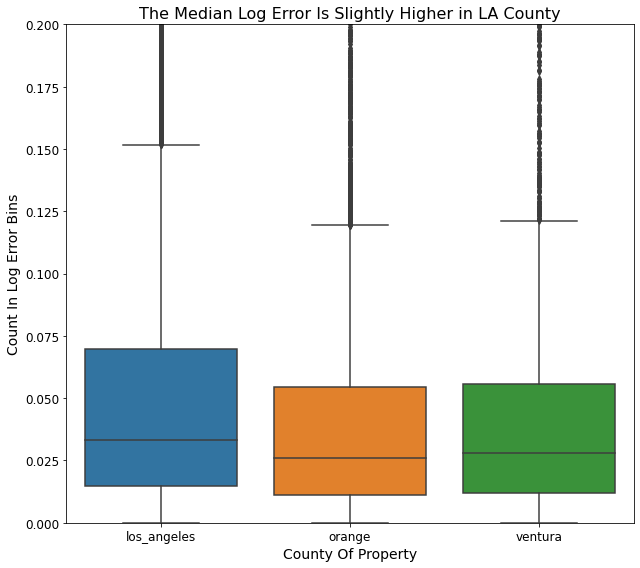

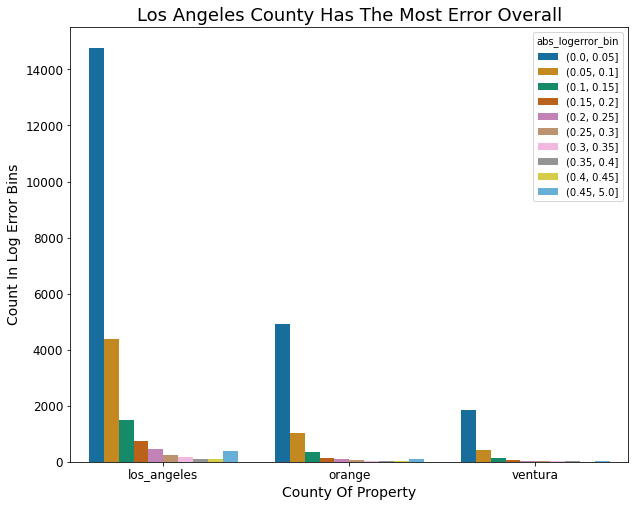

In [12]:
# Plot a boxplot in order to look at the median log error 
plt.figure(figsize=(9,8))
sns.boxplot(train.county, train.abs_logerror)
plt.title('The Median Log Error Is Slightly Higher in LA County', fontsize = 16)
plt.ylim(0, .2)
plt.xlabel('County Of Property', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('Count In Log Error Bins', fontsize = 14)
plt.tight_layout()
plt.show()

# Plot a countplot below it in order to look at the number of log errors
plt.figure(figsize = (10,8))
plt.title('Los Angeles County Has The Most Error Overall', fontsize = 18)
sns.countplot(data = train, x= 'county', hue = 'abs_logerror_bin', palette = 'colorblind')
plt.xlabel('County Of Property', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('Count In Log Error Bins', fontsize = 14)

plt.show()

#### Answer to question #1:
Through the use of our visuals, we see that Los Angeles county has the most errors but htis seems to be brought on my a vast majority of Zestimates being made in the county versus Ventura and Orange. The median of all 3 is very close.

### Question #2:
#### Is there a linear relationship between logerror and age for each county?

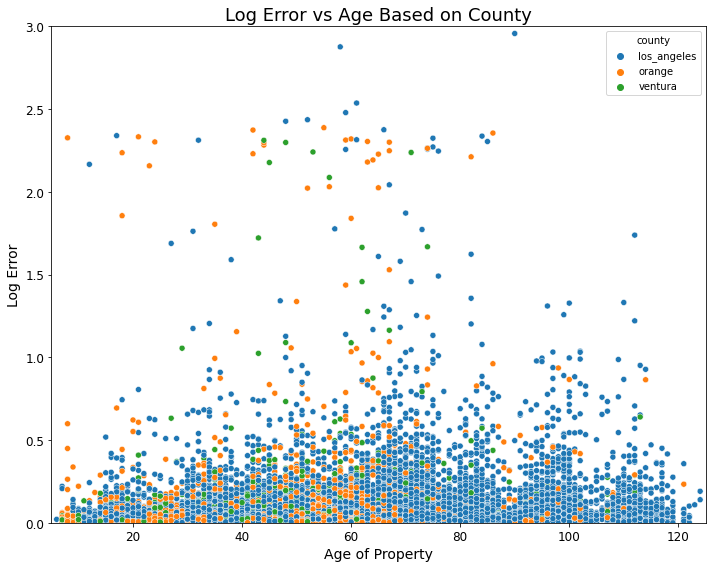

In [13]:
# Define our x and y
x = train['age']
y = train['abs_logerror']
# Set size of figure
plt.figure(figsize = (10,8))
# Create scatterplot
ax = sns.scatterplot(data=train, x= x, y= y, hue="county")
# Set x and y limits to have a more desired look
ax.set(xlim = (5, 125), ylim= (0,3)) # set the limits to the desired ones
# Set labels and title
plt.title('Log Error vs Age Based on County', fontsize = 18)
plt.xlabel('Age of Property', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('Log Error', fontsize = 14)

plt.tight_layout() 
plt.show()

With the visual not allowing us to come to a clear conclusion, let's look to our statistical test...

#### Stats Test (Pearson's r):

    - H0: There is no linear relationship between age and logerror.
    - Ha: There is a linear realtionship between age and log error.

In [14]:
# H0 - There is no linear relationship between age and logerror.
# H1 - There is a linear realtionship between age and log error.
x = train['age']
y = train['abs_logerror']
a = 0.05
r, p = stats.pearsonr(x,y)
print('r =', r)
print('p =', p)
if p < a:
    print("We reject the H0.")
else:
    print("We fail to reject the H0.")

r = 0.11385542955337047
p = 2.437177737036503e-93
We reject the H0.


#### Answer to question #2:
After the visual and Pearson's r test, we are lead to believe that there could be a linear relationship between property age and logerror.

### Question #3:
#### Is there a linear relationship between acres and logerror?/

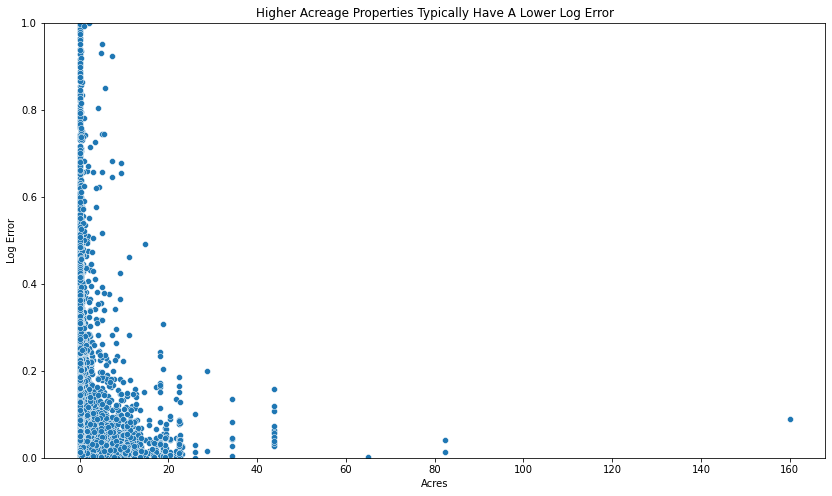

In [15]:
# Plot of log error vs number of bedrooms
f, ax = plt.subplots(figsize=(14, 8))
sns.scatterplot(x = 'acres', y = 'abs_logerror', data = train)
plt.ylim(0,1)
plt.title('Higher Acreage Properties Typically Have A Lower Log Error')
plt.xlabel('Acres')
plt.ylabel('Log Error')
plt.show()

To get a clearer picture, let's look into another Pearson's r...

#### Stats Test (Pearson's r ):

In [16]:
# H0 - There is no linear relationship between acres and logerror.
# H1 - There is a linear realtionship between acres and log error.
x = train['acres']
y = train['abs_logerror']
a = 0.05
r, p = stats.pearsonr(x,y)
print('r =', r)
print('p =', p)
if p < a:
    print("We reject the H0.")
else:
    print("We fail to reject the H0.")

r = 0.0049810839918751765
p = 0.3714913280591692
We fail to reject the H0.


#### Answer to question #3:
After our visual and stats test, we are lead to believe that there is no linear relationship between acres and log error.

## Question 4:
#### What counties have the largest log errors?

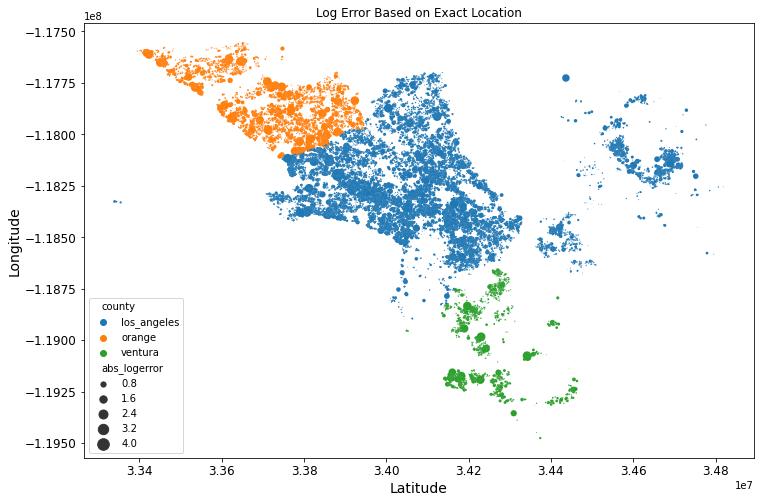

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

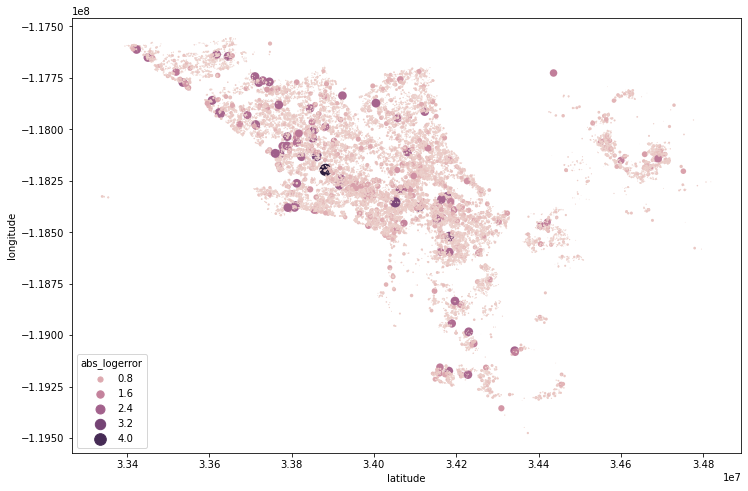

In [17]:
# Plot Locational Data
plt.figure(figsize = (12,8))
sns.scatterplot(x='latitude', y='longitude', hue='county',
                size = 'abs_logerror', sizes = (0,150), data=train)
plt.title('Log Error Based on Exact Location')

plt.xlabel('Latitude', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('Longitude', fontsize = 14)
plt.show()

# Plot absolute log error density
plt.figure(figsize = (12,8))
sns.scatterplot(x='latitude', y='longitude', hue='abs_logerror',
                size = 'abs_logerror', sizes = (0,150), data=train)

#### Answer to question #4
Using our top visual, we see the layout of our counties. In the bottom viz, we see that the most significant errors are found mainly in portions of Los Angeles county and leading into Orange county.

### <u>Clustering:<u>

It is now good practice to scale our data in order the use clustering and diving further into relationships between data. This will be done by our min_max_split function to make, fit, and use a MinMaxScaler on our data...

In [18]:
train_scaled, validate_scaled, test_scaled = w.min_max_split(train, validate, test)

In [19]:
# Set target variables
target_var = 'abs_logerror'

#Make copies of train, validate, and test
train = train_scaled.copy()
validate = validate_scaled.copy()
test = test_scaled.copy()

# create X_train by dropping the target variable 
X_train = train.drop(columns=[target_var])
# create y_train by keeping only the target variable.
y_train = train[[target_var]]

# create X_validate by dropping the target variable 
X_validate = validate.drop(columns=[target_var])
# create y_validate by keeping only the target variable.
y_validate = validate[[target_var]]

# create X_test by dropping the target variable 
X_test = test.drop(columns=[target_var])
# create y_test by keeping only the target variable.
y_test = test[[target_var]]

#### Create a 'location_cluster' using longitude and latitude

In [20]:
 cluster_vars = ['longitude', 'latitude']
cluster_name = 'location_cluster'
# Make the scaler
scaler = sklearn.preprocessing.MinMaxScaler()
# Fit the X_train
scaler.fit(X_train[cluster_vars])
# Scale and transform
X_train_scaled = scaler.transform(X_train[cluster_vars])
X_validate_scaled = scaler.transform(X_validate[cluster_vars])
X_test_scaled = scaler.transform(X_test[cluster_vars])

Let's use our inertia function out of our wrangle.py in order to make sure we are choosing correct number of clusters...

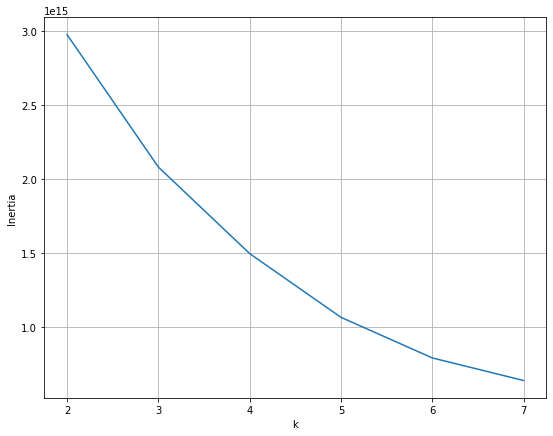

In [21]:
w.inertia(train, 'latitude', 'longitude', 2,8)

In [22]:
# Based on the graph above, we'll choose 3 clusters. 
# Create the object
kmeans = KMeans(n_clusters=3)
# Fit the object
kmeans.fit(X_train_scaled)
# Set preditions
kmeans.predict(X_train_scaled)

array([2, 0, 1, ..., 1, 0, 0], dtype=int32)

In [23]:
# Make predictions and store the predicted cluster back into our original dataframe.
train['location_cluster'] = kmeans.predict(X_train_scaled)
train.location_cluster = train.location_cluster.astype('category')

validate['location_cluster'] = kmeans.predict(X_validate_scaled)
validate.location_cluster = validate.location_cluster.astype('category')

test['location_cluster'] = kmeans.predict(X_test_scaled)
test.location_cluster = test.location_cluster.astype('category')

(-3.0, 3.0)

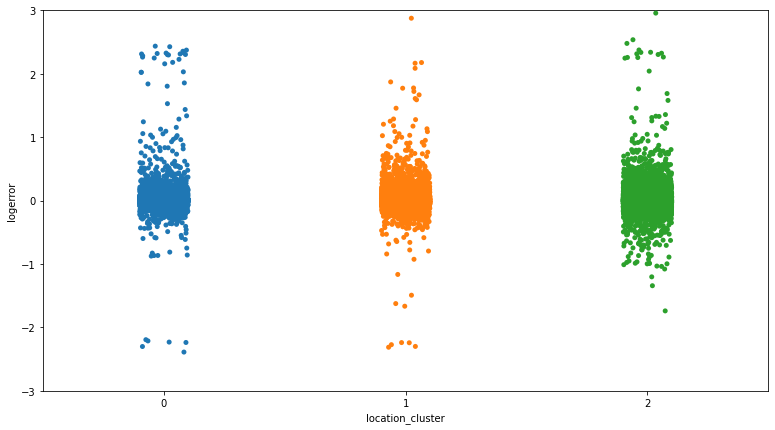

In [24]:
# Set our x and y to see our clusters in action
x = train.location_cluster
y = train.logerror
plt.figure(figsize = (13,7))
ax = sns.stripplot(x=x, y=y, data= train.sample(1000))
plt.ylim(-3,3)

Let's take a look at our clusters in use...

Text(0.5, 1.0, 'Original Data with Cluster Labels')

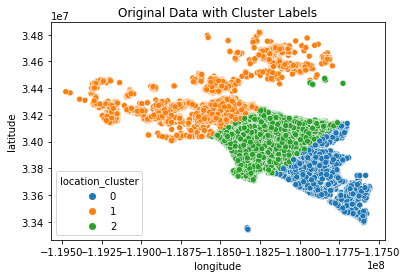

In [25]:
sns.scatterplot(y='latitude', x='longitude', hue='location_cluster', data=train)
plt.title('Original Data with Cluster Labels')

Check out absolute log error to see if our clusters are relevant...

In [26]:
train.groupby('location_cluster')['latitude', 'longitude', 'abs_logerror'].mean()

,latitude,longitude,abs_logerror
location_cluster,,,
0,3.376355e+07,-1.178460e+08,0.060700
1,3.432245e+07,-1.185596e+08,0.062127
2,3.399381e+07,-1.182112e+08,0.071338


We see based on our absolute log error, there seems to be little difference between our clusters. Lets look into a stats test in order to identify which one is more effective.

#### Hypothesis:
 - H0: Absolute log error for location_clusters == Absolute log error mean.
 - Ha: Absolute log error for location_clusters != Absolute log error mean.

In [27]:
# Set the alpha for the test
alpha = .05
# Create variable names to input into our test
train_error = train[train.location_cluster==0].abs_logerror
overall_mean = train.abs_logerror.mean()
# Run the test to retrieve t and p
t,p = stats.ttest_1samp(train_error, overall_mean)
# Run print statements depending on the tests outcome
print(f'{t,p}')
if p/2 > alpha:
    print("We fail to reject the Null Hypothesis")
elif t < 0:
    print("We fail to reject the Null Hypothesis")
else:
    print("We reject the Null Hypothesis")

(-2.8323068199477848, 0.00463282830844223)
We fail to reject the Null Hypothesis


In [28]:
# Set the alpha for the test
alpha = .05
# Create variable names to input into our test
train_error = train[train.location_cluster==1].abs_logerror
overall_mean = train.abs_logerror.mean()
# Run the test to retrieve t and p
t,p = stats.ttest_1samp(train_error, overall_mean)
# Run print statements depending on the tests outcome
print(f'{t,p}')
if p/2 > alpha:
    print("We fail to reject the Null Hypothesis")
elif t < 0:
    print("We fail to reject the Null Hypothesis")
else:
    print("We reject the Null Hypothesis")

(-2.8348456971984906, 0.004594101248473299)
We fail to reject the Null Hypothesis


In [29]:
# Set the alpha for the test
alpha = .05
# Create variable names to input into our test
train_error = train[train.location_cluster==2].abs_logerror
overall_mean = train.abs_logerror.mean()
# Run the test to retrieve t and p
t,p = stats.ttest_1samp(train_error, overall_mean)
# Run print statements depending on the tests outcome
print(f'{t,p}')
if p/2 > alpha:
    print("We fail to reject the Null Hypothesis")
elif t < 0:
    print("We fail to reject the Null Hypothesis")
else:
    print("We reject the Null Hypothesis")

(4.635427529027419, 3.593552549634702e-06)
We reject the Null Hypothesis


#### Findings:
 - location_cluster1 is the most relevant cluster
 - Property with the highest longitudinal distance had the highest absolute logerror
 - Property with the lowest longitudinal distance had the lowest absolute logerror

#### Create a 'house_to_lot_cluster' using longitude and latitude

In [30]:
cluster_vars = ['calculatedfinishedsquarefeet', 'lotsizesquarefeet']
cluster_name = 'house_to_lot_cluster'
# Make scaler
scaler = sklearn.preprocessing.MinMaxScaler()
# Fit the X_train
scaler.fit(X_train[cluster_vars])
# Scale and Transform
X_train_scaled = scaler.transform(X_train[cluster_vars])
X_validate_scaled = scaler.transform(X_validate[cluster_vars])
X_test_scaled = scaler.transform(X_test[cluster_vars])

See how many clusters we should go with using the Elbow Method...

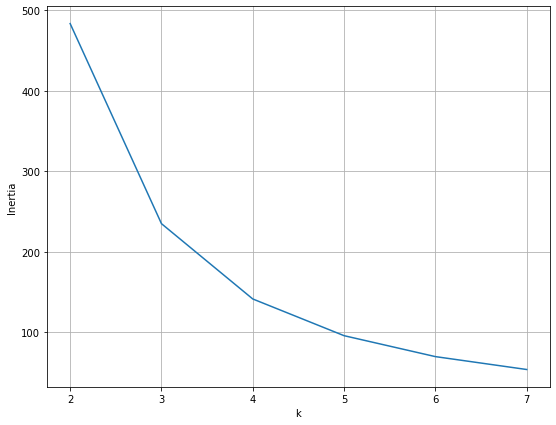

In [31]:
w.inertia(train, 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 2,8)

In [32]:
 # Create the object
kmeans = KMeans(n_clusters=4)
# Fit the object
kmeans.fit(X_train_scaled)
# Set preditions
kmeans.predict(X_train_scaled)

array([2, 1, 3, ..., 3, 2, 0], dtype=int32)

In [33]:
# Make predictions and store the predicted cluster back into our original dataframe.
train['house_to_lot_cluster'] = kmeans.predict(X_train_scaled)
train.house_to_lot_cluster = train.house_to_lot_cluster.astype('category')

validate['house_to_lot_cluster'] = kmeans.predict(X_validate_scaled)
validate.house_to_lot_cluster = validate.house_to_lot_cluster.astype('category')

test['house_to_lot_cluster'] = kmeans.predict(X_test_scaled)
test.house_to_lot_cluster = test.house_to_lot_cluster.astype('category')

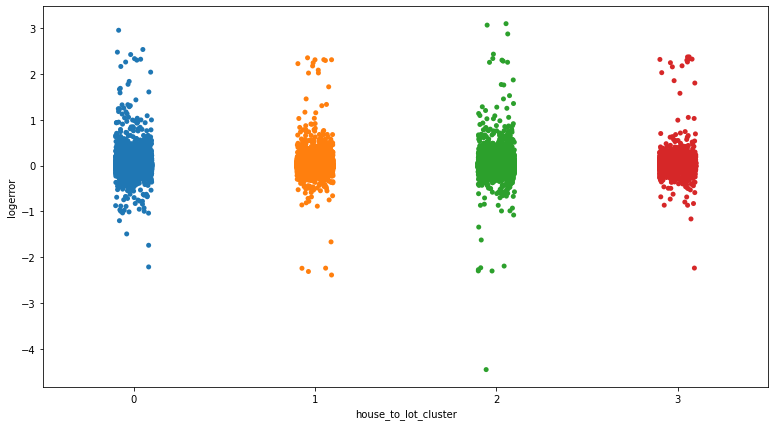

In [34]:
# Set our x and y to see our clusters in action
x = train.house_to_lot_cluster
y = train.logerror
plt.figure(figsize = (13,7))
ax = sns.stripplot(x=x, y=y, data= train.sample(1000))

Take a look at the clusters in action...

Text(0.5, 1.0, 'Original Data with Cluster Labels')

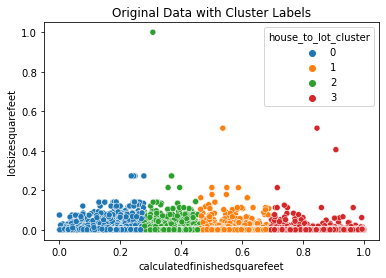

In [35]:
sns.scatterplot(x= 'calculatedfinishedsquarefeet', y = 'lotsizesquarefeet', hue='house_to_lot_cluster', data=train)
plt.title('Original Data with Cluster Labels')

Check out our absolute log error to see if our clusters are relevant...

In [36]:
train.groupby('house_to_lot_cluster')['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'abs_logerror'].mean()

,calculatedfinishedsquarefeet,lotsizesquarefeet,abs_logerror
house_to_lot_cluster,,,
0,0.190001,0.007044,0.074018
1,0.563261,0.003024,0.061930
2,0.364687,0.003857,0.063352
3,0.825629,0.002430,0.062886


Let's run t-test on each cluster to compare the p-values. The higher the p-value, the more significant the cluster actually is.

#### Hypothesis:
 - H0: Absolute log error for house_to_lot_clusters == Absolute log error mean.
 - Ha: Absolute log error for house_to_lot_clusters != Absolute log error mean.

In [37]:
# Set the alpha for the test
alpha = .05
# Create variable names to input into our test
train_error = train[train.house_to_lot_cluster==0].abs_logerror
overall_mean = train.abs_logerror.mean()
# Run the test to retrieve t and p
t,p = stats.ttest_1samp(train_error, overall_mean)
# Run print statements depending on the tests outcome
print(f'{t,p}')
if p/2 > alpha:
    print("We fail to reject the Null Hypothesis")
elif t < 0:
    print("We fail to reject the Null Hypothesis")
else:
    print("We reject the Null Hypothesis")

(5.022315682455076, 5.205832101852278e-07)
We reject the Null Hypothesis


In [38]:
# Set the alpha for the test
alpha = .05
# Create variable names to input into our test
train_error = train[train.house_to_lot_cluster==1].abs_logerror
overall_mean = train.abs_logerror.mean()
# Run the test to retrieve t and p
t,p = stats.ttest_1samp(train_error, overall_mean)
# Run print statements depending on the tests outcome
print(f'{t,p}')
if p/2 > alpha:
    print("We fail to reject the Null Hypothesis")
elif t < 0:
    print("We fail to reject the Null Hypothesis")
else:
    print("We reject the Null Hypothesis")

(-2.4910114475369403, 0.012759166689825317)
We fail to reject the Null Hypothesis


In [39]:
# Set the alpha for the test
alpha = .05
# Create variable names to input into our test
train_error = train[train.house_to_lot_cluster==2].abs_logerror
overall_mean = train.abs_logerror.mean()
# Run the test to retrieve t and p
t,p = stats.ttest_1samp(train_error, overall_mean)
# Run print statements depending on the tests outcome
print(f'{t,p}')
if p/2 > alpha:
    print("We fail to reject the Null Hypothesis")
elif t < 0:
    print("We fail to reject the Null Hypothesis")
else:
    print("We reject the Null Hypothesis")

(-1.883372307192518, 0.05967589049133372)
We fail to reject the Null Hypothesis


In [40]:
# Set the alpha for the test
alpha = .05
# Create variable names to input into our test
train_error = train[train.house_to_lot_cluster==3].abs_logerror
overall_mean = train.abs_logerror.mean()
# Run the test to retrieve t and p
t,p = stats.ttest_1samp(train_error, overall_mean)
# Run print statements depending on the tests outcome
print(f'{t,p}')
if p/2 > alpha:
    print("We fail to reject the Null Hypothesis")
elif t < 0:
    print("We fail to reject the Null Hypothesis")
else:
    print("We reject the Null Hypothesis")

(-1.3729197406203086, 0.16984355903008885)
We fail to reject the Null Hypothesis


#### Findings:
 - house_to_lot_cluster2 is the most relevant cluster
 - Cluster 0 with smaller lot size and median home size had the lowest absolute log error
 - Clusters 1 , as the smallest properties and homes showed the highest absolute log error

#### Create an 'age_acres_cluster' using age and acres

In [41]:
cluster_vars = ['age', 'acres']
cluster_name = 'age_acres_cluster'
# Make the scaler
scaler = sklearn.preprocessing.MinMaxScaler()
# Fit the X_train
scaler.fit(X_train[cluster_vars])
# Scale and transform
X_train_scaled = scaler.transform(X_train[cluster_vars])
X_validate_scaled = scaler.transform(X_validate[cluster_vars])
X_test_scaled = scaler.transform(X_test[cluster_vars])

Determine the appropriate number of cluster to make using the Elbow Method...

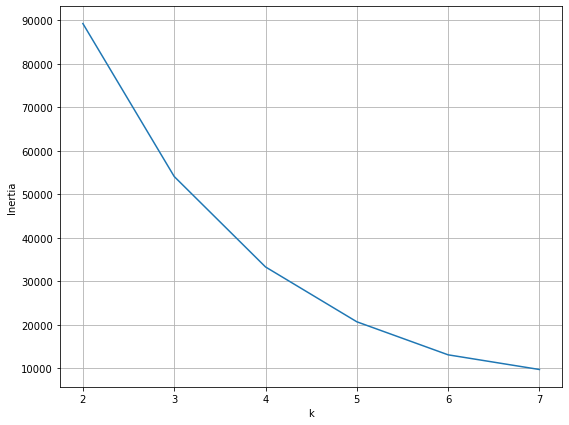

In [42]:
w.inertia(train, 'age', 'acres', 2,8)

There's a clear break at 4 so we'll go with that...

In [43]:
 # Create the object
kmeans = KMeans(n_clusters=4)
# Fit the object
kmeans.fit(X_train_scaled)
# Set preditions
kmeans.predict(X_train_scaled)

array([0, 1, 3, ..., 3, 0, 0], dtype=int32)

In [44]:
# Make predictions and store the predicted cluster back into our original dataframe.
train['age_acres_cluster'] = kmeans.predict(X_train_scaled)
train.age_acres_cluster = train.age_acres_cluster.astype('category')

validate['age_acres_cluster'] = kmeans.predict(X_validate_scaled)
validate.age_acres_cluster = validate.age_acres_cluster.astype('category')

test['age_acres_cluster'] = kmeans.predict(X_test_scaled)
test.age_acres_cluster = test.age_acres_cluster.astype('category')

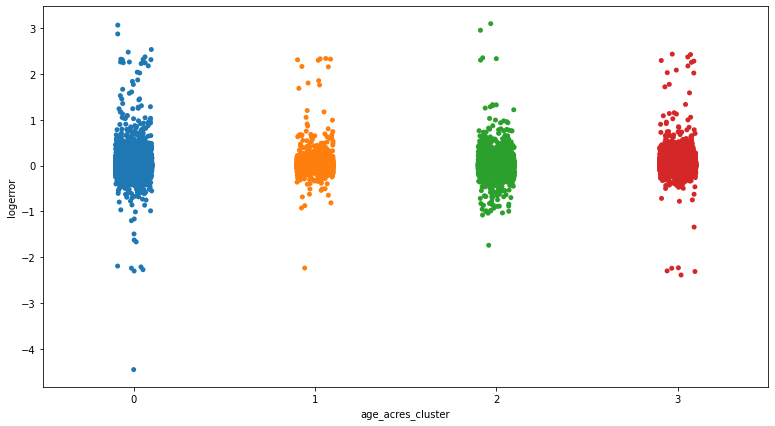

In [45]:
# Set our x and y to see our clusters in action
x = train.age_acres_cluster
y = train.logerror
plt.figure(figsize = (13,7))
ax = sns.stripplot(x=x, y=y, data= train.sample(1000))

See clusters in action...

Text(0.5, 1.0, 'Original Data with Cluster Labels')

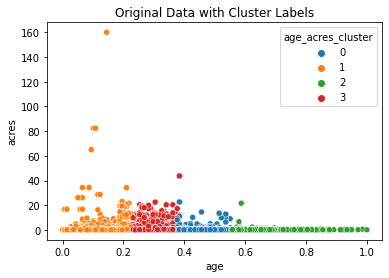

In [46]:
sns.scatterplot(x='age', y='acres', hue='age_acres_cluster', data=train)
plt.title('Original Data with Cluster Labels')

Take a look at how close the absolute log error mean is to establish relevance...

In [47]:
train.groupby('age_acres_cluster')['age', 'acres', 'abs_logerror'].mean()

,age,acres,abs_logerror
age_acres_cluster,,,
0,0.448102,0.259859,0.071532
1,0.154340,0.989551,0.047918
2,0.656989,0.165110,0.103890
3,0.300987,1.318571,0.055930


Run our statistic t-test to take a closer look at relevance...

#### Hypothesis:
 - H0: Absolute log error for age_acres_clusters == Absolute log error mean.
 - Ha: Absolute log error for age_acres_clusters != Absolute log error mean.

In [48]:
# Set the alpha for the test
alpha = .05
# Create variable names to input into our test
train_error = train[train.age_acres_cluster==0].abs_logerror
overall_mean = train.abs_logerror.mean()
# Run the test to retrieve t and p
t,p = stats.ttest_1samp(train_error, overall_mean)
# Run print statements depending on the tests outcome
print(f'{t,p}')
if p/2 > alpha:
    print("We fail to reject the Null Hypothesis")
elif t < 0:
    print("We fail to reject the Null Hypothesis")
else:
    print("We reject the Null Hypothesis")

(4.149284652451522, 3.356447937695292e-05)
We reject the Null Hypothesis


In [49]:
# Set the alpha for the test
alpha = .05
# Create variable names to input into our test
train_error = train[train.age_acres_cluster==1].abs_logerror
overall_mean = train.abs_logerror.mean()
# Run the test to retrieve t and p
t,p = stats.ttest_1samp(train_error, overall_mean)
# Run print statements depending on the tests outcome
print(f'{t,p}')
if p/2 > alpha:
    print("We fail to reject the Null Hypothesis")
elif t < 0:
    print("We fail to reject the Null Hypothesis")
else:
    print("We reject the Null Hypothesis")

(-12.64687470536649, 3.043819758618866e-36)
We fail to reject the Null Hypothesis


In [50]:
# Set the alpha for the test
alpha = .05
# Create variable names to input into our test
train_error = train[train.age_acres_cluster==2].abs_logerror
overall_mean = train.abs_logerror.mean()
# Run the test to retrieve t and p
t,p = stats.ttest_1samp(train_error, overall_mean)
# Run print statements depending on the tests outcome
print(f'{t,p}')
if p/2 > alpha:
    print("We fail to reject the Null Hypothesis")
elif t < 0:
    print("We fail to reject the Null Hypothesis")
else:
    print("We reject the Null Hypothesis")

(12.745527516372844, 2.047659884636633e-36)
We reject the Null Hypothesis


In [51]:
# Set the alpha for the test
alpha = .05
# Create variable names to input into our test
train_error = train[train.age_acres_cluster==3].abs_logerror
overall_mean = train.abs_logerror.mean()
# Run the test to retrieve t and p
t,p = stats.ttest_1samp(train_error, overall_mean)
# Run print statements depending on the tests outcome
print(f'{t,p}')
if p/2 > alpha:
    print("We fail to reject the Null Hypothesis")
elif t < 0:
    print("We fail to reject the Null Hypothesis")
else:
    print("We reject the Null Hypothesis")

(-7.456298145833298, 9.718602582647136e-14)
We fail to reject the Null Hypothesis


#### Findings:
 - age_acres_cluster0 is the most relevant cluster 
 - Newer, smaller properties result in a lower absolute log error.

### Modeling

We start by creating a function that takes in train validate and test then returns dummmy variables for the folllowing categories:
   
   - age_bin
   - county
   - county_code_bin
   - abs_logerror_bin
   - logerror_bin

Then returns that train, validate, and test with the dummies.

In [52]:
train, validate, test = w.get_zillow_dummies(train, validate, test, cat_columns = ['age_bin', 'county', 'county_code_bin', 
                                                                               'abs_logerror_bin', 'logerror_bin'])

Then scale that train, validate, and test...

In [53]:
train_scaled, validate_scaled, test_scaled = w.min_max_split(train, validate, test)

#### Set Baseline

In [54]:
# Turn y_train and y_validate into dataframes so we can append new columns
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

#Calculate tax_value median
abs_logerror_pred_median = y_train['abs_logerror'].median()
y_train['abs_logerror_pred_median'] = abs_logerror_pred_median
y_validate['abs_logerror_pred_median'] = abs_logerror_pred_median

# Calcualte RMSE of tax_value_pred_mean
basemedian_rmse_train = mean_squared_error(y_train.abs_logerror, y_train.abs_logerror_pred_median)**(1/2)
basemedian_rmse_validate = mean_squared_error(y_validate.abs_logerror, y_validate.abs_logerror_pred_median)**(1/2)

# Add the baseline column
train_scaled['baseline'] = train_scaled.abs_logerror.median()


In [55]:
# Define x's and y's then make them int a dataframe.
X_cols = list(train_scaled.drop(columns = ['abs_logerror', 'logerror', 'baseline']))
y_cols = 'abs_logerror'


X_train = train_scaled[X_cols]
y_train = pd.DataFrame(train[y_cols])

X_validate = validate_scaled[X_cols]
y_validate = pd.DataFrame(validate[y_cols])

X_test = test_scaled[X_cols]
y_test = pd.DataFrame(test[y_cols])

#### Define features/target then model

In [56]:
features = ['age_acres_cluster', 'house_to_lot_cluster', 'location_cluster']
target = ['abs_logerror']

#### OLS Linear Regression:

In [57]:
# Create the model
lm = LinearRegression(normalize=True)

# Fit the model 
lm.fit(X_train[features], y_train.abs_logerror)

# Set predictions
y_train['abs_logerror_pred_lm'] = lm.predict(X_train[features])

# Evaluate RMSE for train
rmse_train = mean_squared_error(y_train.abs_logerror, y_train.abs_logerror_pred_lm)**(1/2)

# Predict validate 
y_validate['abs_logerror_pred_lm'] = lm.predict(X_validate[features])

# Evaluate RMSE on validate
rmse_validate = mean_squared_error(y_validate.abs_logerror, y_validate.abs_logerror_pred_lm)**(1/2)


#### LassoLars:

In [58]:
# Create the model
lars = LassoLars(alpha=1.0)

# Fit the model  
lars.fit(X_train[features], y_train.abs_logerror)

# Predict train
y_train['abs_logerror_pred_lars'] = lars.predict(X_train[features])

# Evaluate RMSEon validate
rmse_train2 = mean_squared_error(y_train.abs_logerror, y_train.abs_logerror_pred_lars)**(1/2)

# predict validate
y_validate['abs_logerror_pred_lars'] = lars.predict(X_validate[features])

# evaluate: rmse
rmse_validate2 = mean_squared_error(y_validate.abs_logerror, y_validate.abs_logerror_pred_lars)**(1/2)


#### TweedieRegressor (GLM):

In [59]:
# Create the model
glm = TweedieRegressor(power=1, alpha=0)

#Fit the model 
glm.fit(X_train[features], y_train.abs_logerror)

# Predict train
y_train['abs_logerror_pred_glm'] = glm.predict(X_train[features])

# Evaluate: rmse
rmse_train3 = mean_squared_error(y_train.abs_logerror, y_train.abs_logerror_pred_glm)**(1/2)

# Predict validate
y_validate['abs_logerror_pred_glm'] = glm.predict(X_validate[features])

# Evaluate: rmse
rmse_validate3 = mean_squared_error(y_validate.abs_logerror, y_validate.abs_logerror_pred_glm)**(1/2)


#### Polynomial Features

In [60]:
# Make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# Fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train[features])

# Transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate[features])
# x_test_degree2 = pf.transform(x_test)

In [61]:
# Create the model
lm2 = LinearRegression(normalize=True)

# Fit the model 
lm2.fit(X_train_degree2, y_train.abs_logerror)

# Set predictions
y_train['abs_logerror_pred_lm2'] = lm2.predict(X_train_degree2)

# Evaluate RMSE for train
rmse_train4 = mean_squared_error(y_train.abs_logerror, y_train.abs_logerror_pred_lm2)**(1/2)

# Predict validate 
y_validate['abs_logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

# Evaluate RMSE for validate
rmse_validate4 = mean_squared_error(y_validate.abs_logerror, y_validate.abs_logerror_pred_lm2)**(1/2)


In [62]:
print('===================================================')
print("RMSE for Baseline using Median\nTrain/In-Sample: ", round(basemedian_rmse_train, 7), 
      "\nValidate/Out-of-Sample: ", round(basemedian_rmse_validate, 7))
print('===================================================')
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train,7), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate,7))
print('---------------------------------------------------')
print("RMSE for Lasso + Lars\nTraining/In-Sample: ", round(rmse_train2,7), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate2,7))
print('---------------------------------------------------')
print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", round(rmse_train3,7), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate3,7))
print('---------------------------------------------------')
print("RMSE for Polynomial Features using LinearRegression\nTraining/In-Sample: ", round(rmse_train4,7), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate4,7))
print('===================================================')

RMSE for Baseline using Median
Train/In-Sample:  0.1482185 
Validate/Out-of-Sample:  0.1537568
RMSE for OLS using LinearRegression
Training/In-Sample:  0.1440131 
Validation/Out-of-Sample:  0.1495823
---------------------------------------------------
RMSE for Lasso + Lars
Training/In-Sample:  0.1441396 
Validation/Out-of-Sample:  0.149651
---------------------------------------------------
RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  0.1440149 
Validation/Out-of-Sample:  0.1495844
---------------------------------------------------
RMSE for Polynomial Features using LinearRegression
Training/In-Sample:  0.1439473 
Validation/Out-of-Sample:  0.1494112


#### Run our best model (Polynomial Features) on our Test dataset...

In [63]:
# Create the model
lm = LinearRegression(normalize=True)

# Fit the model 
lm.fit(X_test[features], y_test.abs_logerror)

# Set predictions
y_test['abs_logerror_pred_lm'] = lm.predict(X_test[features])

# Evaluate RMSE for train
rmse_test = mean_squared_error(y_test.abs_logerror, y_test.abs_logerror_pred_lm)**(1/2)

# Predict validate 
y_test['abs_logerror_pred_lm'] = lm.predict(X_test[features])

# Evaluate RMSE on validate
rmse_validate = mean_squared_error(y_validate.abs_logerror, y_validate.abs_logerror_pred_lm)**(1/2)

print ('---------------------------------------------')
print("Baseline RMSE for Validate Sample: ", round(basemedian_rmse_validate, 7))
print("RMSE for Test Sample: ", round(rmse_test,7))
print ('---------------------------------------------')
print("Our model beats the baseline by ", (round(basemedian_rmse_validate-rmse_test,7)))
print ('---------------------------------------------')

---------------------------------------------
Baseline RMSE for Validate Sample:  0.1537568
RMSE for Test Sample:  0.1385657
---------------------------------------------
Our model beats the baseline by  0.015191
---------------------------------------------


### Conclusion:
#### The goals of this project were to identify key drivers of tax value for single family residential homes purchased during 2017. These key drivers were found to be the following created clusters:

- age_acres_cluster
- location_cluster
- house-to_lot_cluster

#### Using these drivers, the model will decrease log error by 0.015191


### Recommendation(s):
While our model does improve slightly on absolute log error, higher quality data is needed in order for larger gains.

### Next Steps:
#### With more time, I would like to:

- Work on more feature engineering and explore relationships of categories to log error further.

- Gather more adequate and complete data that will allow for a clearer picture and the possibility for a more refined and detailed model.